In [1]:
%matplotlib notebook

import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from numpy import pi
import matplotlib.pyplot as plt
from qutip import *
from typing import Tuple

from basics import *
from hybrid_matrix_elements import *
from atomic_physics import *

In [2]:
def projector(dimensions, state_index):
    pj = np.zeros((dimensions, dimensions),dtype=int)
    pj[state_index,state_index] = 1
    return Qobj(pj)

## Experiment Parameters

In [478]:
p_ge = 100e-3  # W
p_er = 35e-3  # W
w_ge = 14e-6  # m
w_er = 5e-6  # m
phi_ge = 0  # phase on 684nm field
phi_er = 0  # phase of 595nm field
pol_scheme = ["pipi","sigsig","sigx","sigpi","sigpm"][-1]
scheme_lab = {
    "pipi": "$\pi-\pi$",
    "sigsig": "$\sigma-\sigma$",
    "sigx": "$\sigma-X$",
    "sigpi": "$\sigma-\pi$",
    "sigpm": "$\sigma_+-\sigma_-$"
}

if pol_scheme == "sigsig":
    # sigma-sigma polarization scheme
    pol_ge = SphericalVector([0,1,0], spherical_basis=True)  # sigma+ polarized
    pol_er = SphericalVector([0,1,0])  # sigma+ polarized
    k_ar = SphericalVector([1,0,0], spherical_basis=True)  # Z polarized
elif pol_scheme == "pipi":
    # pi-pi polarization scheme
    pol_ge = SphericalVector([1,0,0], spherical_basis=True)  # pi polarized
    pol_er = SphericalVector([1,0,0])  # pi polarized
    k_ar = SphericalVector([1,0,0], spherical_basis=False)  # X polarized
elif pol_scheme == "sigx":
    # sigma-x
    pol_ge = SphericalVector([0,1,0], spherical_basis=True)  # sigma+ polarized
    pol_er = SphericalVector([1,0,0], spherical_basis=False)  # x polarized
    k_ar = SphericalVector([1,0,0], spherical_basis=True)  # Z polarized
elif pol_scheme == "sigpi":
    # sigma-pi
    pol_ge = SphericalVector([0,1,0], spherical_basis=True)  # sigma+ polarized
    pol_er = SphericalVector([1,0,0], spherical_basis=True)  # z polarized
    k_ar = SphericalVector([1,0,0], spherical_basis=True)  # Z polarized
elif pol_scheme == "sigpm":
    # sigma-\pm
    pol_ge = SphericalVector([0,1,0], spherical_basis=True)  # sigma+ polarized
    pol_er = SphericalVector([0,0,1], spherical_basis=True)  # sigma- polarized
    k_ar = SphericalVector([1,0,0], spherical_basis=True)  # Z polarized
    
nr = 52  # Target Rydberg State
bias_B = 6 * gauss # bias field in the z-direction

# Laser detunings
intermediate_detuning = -160
detuning = 2*pi*1e6*intermediate_detuning  # Detuning from the ground-excited (F'=6) transition
# Simulated AC start shifts
dAC = 0  # To target |nrP3/2,1/2> state
dAC = 0  # To target |nrP3/2,-1/2> state
delta = np.array([detuning - DET for DET in DHF])  # Intermediate detunings for each state
little_delta = 0 # zeeman_R(bias_B, nr, -1/2)+dAC  # two-photon detuning from unperturbed |nrP3/2> level

# Lists of quantum numbers being tracked
fs = range(1,7,1)  # Intermediate f levels
mfs = [-2,-1,0,1,2]  # Intermediate mf states being considered. Other mf's are uncoupled from light fields
mrs = np.arange(-3/2,3/2+1,1)  # Rydberg Zeeman states

In [479]:
print("\n".join([f"\Delta_{f} = {delta[f]/2/pi*1e-6:.2f}MHz" for f in fs]))

\Delta_1 = -584.81+0.00jMHz
\Delta_2 = -542.32+0.00jMHz
\Delta_3 = -478.59+0.00jMHz
\Delta_4 = -393.62+0.00jMHz
\Delta_5 = -287.42+0.00jMHz
\Delta_6 = -160.00+0.00jMHz


## Atomic Physics constants

In [480]:
n_eff = nr - defect_p_3o2(nr)
gamma_r = 1/ryd_lifetime_np3o2(n_eff, 300)

# Simulate Dynamics Using Qutip
## Define Hamiltonian and State Vector

In [481]:
# If fullH is False, only mf=-2,-1,0,1,2 states in the 5D5/2 manifold are included in Hilbert space, otherwise ALL mf levels are included
fullH=True  # Model ALL levels in 5D5/2 manifold
if fullH:
    dim = 1+48+4+1 # 1 ground, 48 excited, 4 rydberg, 1 aux depumped state 
    def find(f,mf):
        if abs(mf) > f or f not in fs:
            return -1
        return 1 + f**2 + f - 1 + mf
    ryd_ind = lambda mr: int(mr+3/2)+find(6,6)+1
else:
    dim = 1+28+4+1 # 1 ground, 28 excited, 4 rydberg, 1 aux depumped state
    def find(f,mf):
        if abs(mf) > f:
            return -1
        if f == 1:
            return 3*f+mf-1
        else:
            return 5*f+mf-4
    ryd_ind = lambda mr: int(mr + 3/2)+29
aux_ind = dim-1

# Initialize hamiltonian and state
H = np.zeros((dim,dim),dtype=complex)
psi_0 = basis(dim,0)


for f in fs:
    for mf in range(-f,f+1):
        if find(f,mf) == -1:
            continue
        # print(f"|f,mf = {f,mf}>, ind = {find(f,mf)}")
        # Ground - Excited Rabi frequencies
        H[0,find(f,mf)] = q_rabi_frequency(p_ge, w_ge, pol_ge, k_ar, q_rad_int, f, mf, phi_ge)/2
        H[find(f,mf),0] = H[0,find(f,mf)].conjugate()
        # Detuning from intermediate state
        # print(delta[f])
        H[find(f,mf),find(f,mf)] = delta[f] - zeeman_e(bias_B, f, mf)
        
        # Excited - Rydberg Rabi frequencies
        for mr in mrs:
            #print(mr,ryd_ind(mr))
            H[find(f,mf),ryd_ind(mr)] = d_rabi_frequency(p_er, w_er, pol_er, nr, f, mf, mr, phi_er)/2
            H[ryd_ind(mr),find(f,mf)] = H[find(f,mf),ryd_ind(mr)].conjugate()
            H[ryd_ind(mr),ryd_ind(mr)] = little_delta - zeeman_R(bias_B, nr, mr)

## Define Decay Matrices

# Decay Branching Ratios

## $5D_{5/2}$

Main decay channel is only dipole allowed transition, $5D_{5/2}\rightarrow6P_{3/2} \rightarrow 6S_{1/2}$

P state isn't modeled. Decay is modeled from D directly to S, as P state lifetimes are very small

### Notation
 * $|f_e,m_e> \equiv |5D_{5/2};f_e,m_e>$ Excited state
 * $|f_p,m_p> \equiv |6P_{3/2};f_p,m_p>$ Intermediate P state
 * $|f_s,m_s> \equiv |6S_{1/2};f_s,m_s>$ Ground state
### Decay between hyperfine levels
$$ b_{f_e,f_p} = (2f_e+1)\left(S^{5/2,7/2,f_e}_{f_p,1,3/2}\right)^2$$
$$ b_{f_p,f_s} = (2f_p+1)\left(S^{3/2,7/2,f_p}_{f_s,1,1/2}\right)^2$$

### Decay between f,m states
$$ b_{f_e,m_e;f_p,m_p} = b_{f_e,f_p}\left(C^{f_p,m_p}_{f_e,m_e,1,(m_p-m_e)}\right)^2$$
$$ b_{f_p,m_p;f_s,m_s} = b_{f_p,f_e}\left(C^{f_s,m_s}_{f_p,m_p,1,(m_s-m_p)}\right)^2$$

### Decay between $f_e,m_e and f_s,m_s$

$$ b_{f_e,m_e;f_s,m_s} = \sum_{f_p,m_p} b_{f_e,m_e;f_p,m_p}b_{f_p,m_p;f_s,m_s} $$

$$ b_{f_e,m_e;f_s,m_s} = \sum_{f_p = f_e-1}^{f_e+1} b_{f_e,f_p} \sum_{m_p = m_e-1}^{m_e+1} b_{f_p,f_s} \left(C^{f_p,m_p}_{f_e,m_e,1,(m_p-m_e)}C^{f_s,m_s}_{f_p,m_p,1,(m_s-m_p)}\right)^2  $$

### Decay to "pumped" state
$$ b_T^{(f_e,m_e)} = \sum_{f_s,m_s} b_{f_e,m_e;f_s,m_s} $$

$$ b_P^{(f_e,m_e)} = \frac{b_{f_e,m_e;4,0}}{b_T^{(f_e,m_e)}} $$

into all other states (modeled as "depumped" state)

$$ b_D^{(f_e,m_e)} = 1-b_P^{(f_e,m_e)} $$

## $nP_{3/2}$

Assuming main decay channel is to HF ground states along dipole transition

### Notation
 * $|m_r> = |nP_{3/2},m_r>$  rydberg state (FS)
 * $|f_g,m_g> = |6S_{1/2};f_g,m_g>$ ground state (HF)
 
### decompose from FS to HF

$$ |I,j;m_i,m_j> = \sum_{f,m_f} |I,j;f,m_f> C^{f,m_f}_{I,m_i,j,m_j} $$

$|j,m_j>$ states are good quantum numbers, but all $m_i$ states are degenerate. So we Average over $m_i$ states when describing $|j,m_j>$ states

$$ |j,m_j> = \frac{1}{\sqrt{2I+1}}\sum_{m_i} |I,j,m_i,m_j> $$

Decomposing these states in the HF basis:

$$ |j,m_j> = \frac{1}{\sqrt{2I+1}}\sum_{m_i} \sum_{f,m_f} |I,j;f,m_f> C^{f,m_f}_{I,m_i,j,m_j} $$
from the selection rules we know that the Clebsch Gordan coefficient is zero unless $ m_i = m_f-m_j $

$$ |j,m_j> = \frac{1}{\sqrt{2I+1}} \sum_{f,m_f} |I,j;f,m_f> C^{f,m_f}_{I,(m_f-m_j),j,m_j} $$

### branching ratios

**from $f_r,m_f$ to $f_g,m_g$**
 
$$ b_{f_r,m_f;f_g,m_g} = (2f_r+1)\left(S^{3/2,7/2,f_r}_{f_g,1,1/2} C^{f_g,m_g}_{f_r,m_f,1,(m_g-m_f)})\right)^2$$

**from $m_j$ to $f_g,m_g$**

$$ b_{m_r;f_g,m_g} = \sum_{f_r,m_f} (2f_r+1) \left(S^{3/2,7/2,f_r}_{f_g,1,1/2} C^{f_g,m_g}_{f_r,m_f,1,(m_g-m_f)}) C^{f,m_f}_{I,(m_f-m_r),3/2,m_r}\right)^2 $$

In [483]:
# Branching ratios for excited-ground decay
## decay from f_e to f_p
b_ep = lambda fe,fp : (2*fe+1)*wigner_6j(5/2,7/2,fe,fp,1,3/2)**2
b_ps = lambda fp,fs : (2*fp+1)*wigner_6j(3/2,7/2,fp,fs,1,1/2)**2

b_qp = lambda fe,me,fp,mp : b_ep(fe,fp)*clebsch_gordan(fe,1,fp,me,(mp-me),mp)**2
b_pg = lambda fp,mp,fs,ms : b_ps(fp,fs)*clebsch_gordan(fp,1,fs,mp,(ms-mp),ms)**2

def b_eg(fe,me,fs,ms):
    hf_ps = [5,4,3,2]  # exising intermediate hyperfine levels
    fps = [fp for fp in [fe-1,fe,fe+1] if fp in hf_ps]  # decay channels in HF levels
    
    b = 0
    for fp in fps:
        for mp in [me-1,me,me+1]:
            if abs(mp) > fp:
                continue
            b += b_qp(fe,me,fp,mp)*b_pg(fp,mp,fs,ms)
    return b

def b_T(fe,me):
    b3 = sum([b_eg(fe,me,3,ms) for ms in range(-3,4)])  # into f=3
    b4 = sum([b_eg(fe,me,4,ms) for ms in range(-4,5)])  # into f=4
    return b3+b4

def b_pump(fe,me):
    return b_eg(fe,me,4,0)/b_T(fe,me)

# Branchin Ratios for rydberg-Ground decay

# between hyperfine levels
b_hf_f = lambda fr,fg : (2*fr+1)*wigner_6j(3/2,7/2,fr,fg,1,1/2)**2
# between hyperfine zeeman states
b_hf_rg = lambda fr,mf,fg,mg : b_hf_f(fr,fg)*clebsch_gordan(fr,1,fg,mf,(mg-mf),mg)**2

def b_rg(mr,fg,mg):
    hf_rs = [5,4,3,2]  # Rydberg hyperfine levels
    frs = [fr for fr in [fg-1,fg,fg+1] if fr in hf_rs]  # decay channels in HF levels
    
    b = 0
    for fr in frs:
        for mf in [mg-1,mg,mg+1]:
            if abs(mf) > fr:
                continue
        b += b_hf_rg(fr,mf,fg,mg)*clebsch_gordan(7/2,3/2,fr,(mf-mr),mr,mf)**2
    return b

def b_rg_T(mr):
    b3 = sum([b_rg(mr,3,mg) for mg in range(-3,4)])
    b4 = sum([b_rg(mr,4,mg) for mg in range(-4,5)])
    return b3+b4

def b_rg_P(mr):
    return b_rg(mr,4,0)/b_rg_T(mr)

In [484]:
def destructor(dimensions: int, ind: int, rate: float, branching: float = 1) -> Tuple[Qobj,Qobj]:
    """
    Creates an annihilation operator compatible with a system of the specified dimensions, where the 0th state is the ground 
    state.
    Args:
        dimensions: number of dimensions in the Hilbert Space
        ind: index or indeces of the states which this operator acts on
        rate: the decay rate of this state.
        branching: fraction of branching ratio that decays into ground state, rest of ratio falls into depumped aux state
        
    Returns:
        Qobjs representing an annihilation operators that takes the state (or states) specified by ind to the pumped ground
            state and depumped ground states
    """
    nd_op_pumped = np.zeros((dimensions, dimensions), dtype=complex)
    nd_op_pumped[0,ind] = branching*np.sqrt(rate)  # Decay that falls into qubit ground state
    
    nd_op_depumped = np.zeros((dimensions, dimensions), dtype=complex)
    nd_op_depumped[aux_ind,ind] = (1-branching)*np.sqrt(rate)  # Decay that doesn't fall into pumped state (eg other zeeman states)
    return Qobj(nd_op_pumped), Qobj(nd_op_depumped)

collapse = []
for f in fs:
    for mf in range(-f,f+1):
        if find(f,mf) == -1:
            continue
        branching = float(b_pump(f,mf))
        #print(f"|fe={f},me={mf}>: b_P = {branching}")
        collapse += destructor(dim, find(f, mf), gamma_e, branching)
for mr in mrs:
    branching = float(b_rg_P(mr))
    collapse += destructor(dim, ryd_ind(mr), gamma_r, branching)

## Simulate Oscillations for many detunings

In [485]:
m_r = -1/2
H_cp = H.copy()
t_list = np.linspace(0, 2e-6, 200)
detunings = 2*pi*1e6*(float(zeeman_R(bias_B,nr,m_r))*1e-6/2/pi+np.linspace(-4,4,21))
Ps = np.zeros((dim, len(detunings), len(t_list)),dtype = float)

for i, det in enumerate(detunings):
    for mr in mrs:
        H_cp[ryd_ind(mr), ryd_ind(mr)] = H[ryd_ind(mr), ryd_ind(mr)] + det
    
    H_qtip = Qobj(H_cp)
    result = mesolve(H_qtip, psi_0, t_list, collapse, [], progress_bar=True)
    Ps[:,i,:] = expect([projector(dim,d) for d in range(dim)],result.states)

10.0%. Run time:   0.93s. Est. time left: 00:00:00:08
20.0%. Run time:   1.84s. Est. time left: 00:00:00:07
30.0%. Run time:   2.72s. Est. time left: 00:00:00:06
40.0%. Run time:   3.61s. Est. time left: 00:00:00:05
50.0%. Run time:   4.52s. Est. time left: 00:00:00:04
60.0%. Run time:   5.44s. Est. time left: 00:00:00:03
70.0%. Run time:   6.34s. Est. time left: 00:00:00:02
80.0%. Run time:   7.25s. Est. time left: 00:00:00:01
90.0%. Run time:   8.16s. Est. time left: 00:00:00:00
Total run time:   9.02s
10.0%. Run time:   0.90s. Est. time left: 00:00:00:08
20.0%. Run time:   1.83s. Est. time left: 00:00:00:07
30.0%. Run time:   2.77s. Est. time left: 00:00:00:06
40.0%. Run time:   3.67s. Est. time left: 00:00:00:05
50.0%. Run time:   4.57s. Est. time left: 00:00:00:04
60.0%. Run time:   5.48s. Est. time left: 00:00:00:03
70.0%. Run time:   6.39s. Est. time left: 00:00:00:02
80.0%. Run time:   7.31s. Est. time left: 00:00:00:01
90.0%. Run time:   8.24s. Est. time left: 00:00:00:00
Tota

20.0%. Run time:   1.80s. Est. time left: 00:00:00:07
30.0%. Run time:   2.71s. Est. time left: 00:00:00:06
40.0%. Run time:   3.61s. Est. time left: 00:00:00:05
50.0%. Run time:   4.51s. Est. time left: 00:00:00:04
60.0%. Run time:   5.43s. Est. time left: 00:00:00:03
70.0%. Run time:   6.33s. Est. time left: 00:00:00:02
80.0%. Run time:   7.25s. Est. time left: 00:00:00:01
90.0%. Run time:   8.16s. Est. time left: 00:00:00:00
Total run time:   9.02s
10.0%. Run time:   0.90s. Est. time left: 00:00:00:08
20.0%. Run time:   1.80s. Est. time left: 00:00:00:07
30.0%. Run time:   2.71s. Est. time left: 00:00:00:06
40.0%. Run time:   3.61s. Est. time left: 00:00:00:05
50.0%. Run time:   4.52s. Est. time left: 00:00:00:04
60.0%. Run time:   5.44s. Est. time left: 00:00:00:03
70.0%. Run time:   6.36s. Est. time left: 00:00:00:02
80.0%. Run time:   7.26s. Est. time left: 00:00:00:01
90.0%. Run time:   8.17s. Est. time left: 00:00:00:00
Total run time:   9.02s
10.0%. Run time:   0.91s. Est. tim

<IPython.core.display.Javascript object>


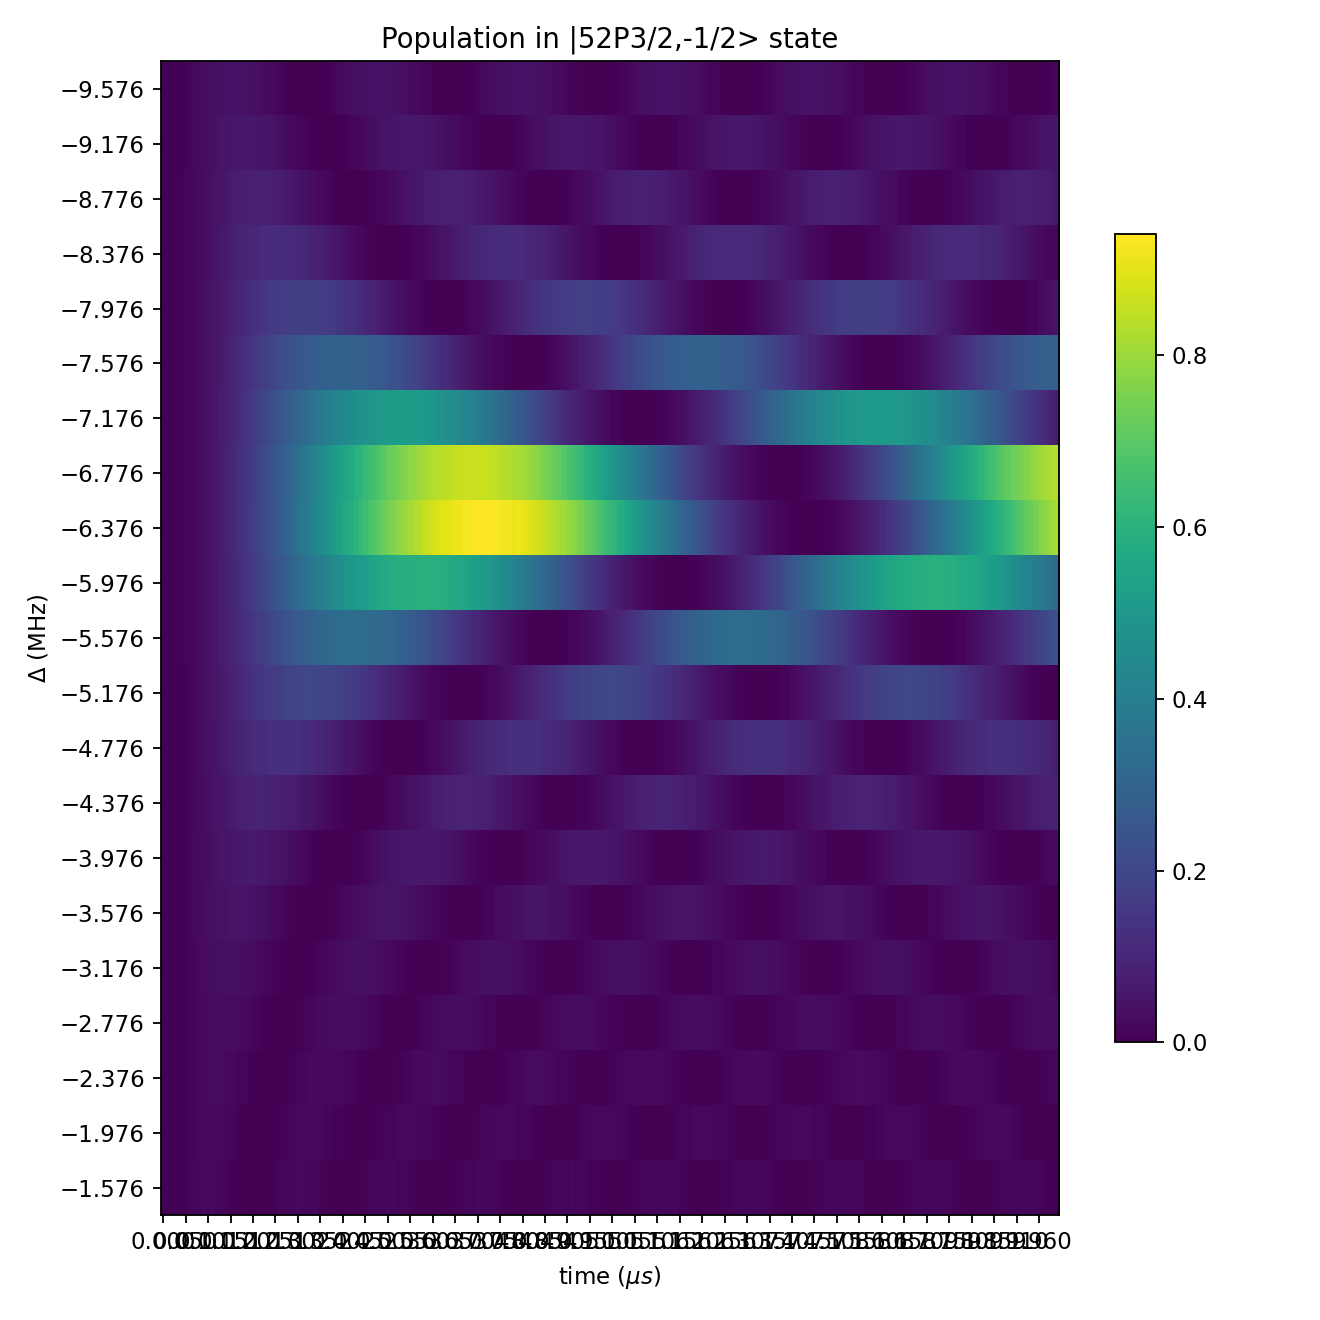

In [486]:
mr = m_r
PT = Ps[ryd_ind(mr)]
fig,ax = plt.subplots(1,1,figsize=(8,8))
dets = detunings*1e-6/2/pi
detuning_steps = dets[1] - dets[0]
ts = t_list*1e6  # to us
ts_steps = ts[1] - ts[0]
extent = [
    min(ts - ts_steps / 2),  # left
    max(ts + ts_steps / 2),  # right
    max(dets + detuning_steps / 2),  # bottom
    min(dets - detuning_steps / 2)   # top
]
extent = [float(val) for val in extent]
im = ax.imshow(PT, interpolation='none', aspect='auto', extent=extent)
ax.set_xlabel("time ($\mu s$)")
ax.set_ylabel("$\Delta$ (MHz)")
ax.set_xticks(ts[::5])
ax.set_yticks(dets)
ax.set_title(f"Population in |{nr}P3/2,{int(2*mr)}/2> state")
fig.tight_layout()
fig.colorbar(im, ax=ax, use_gridspec=True, shrink=.7)
fig.show()
#fig.savefig("PiPulsetom1.png")

<IPython.core.display.Javascript object>


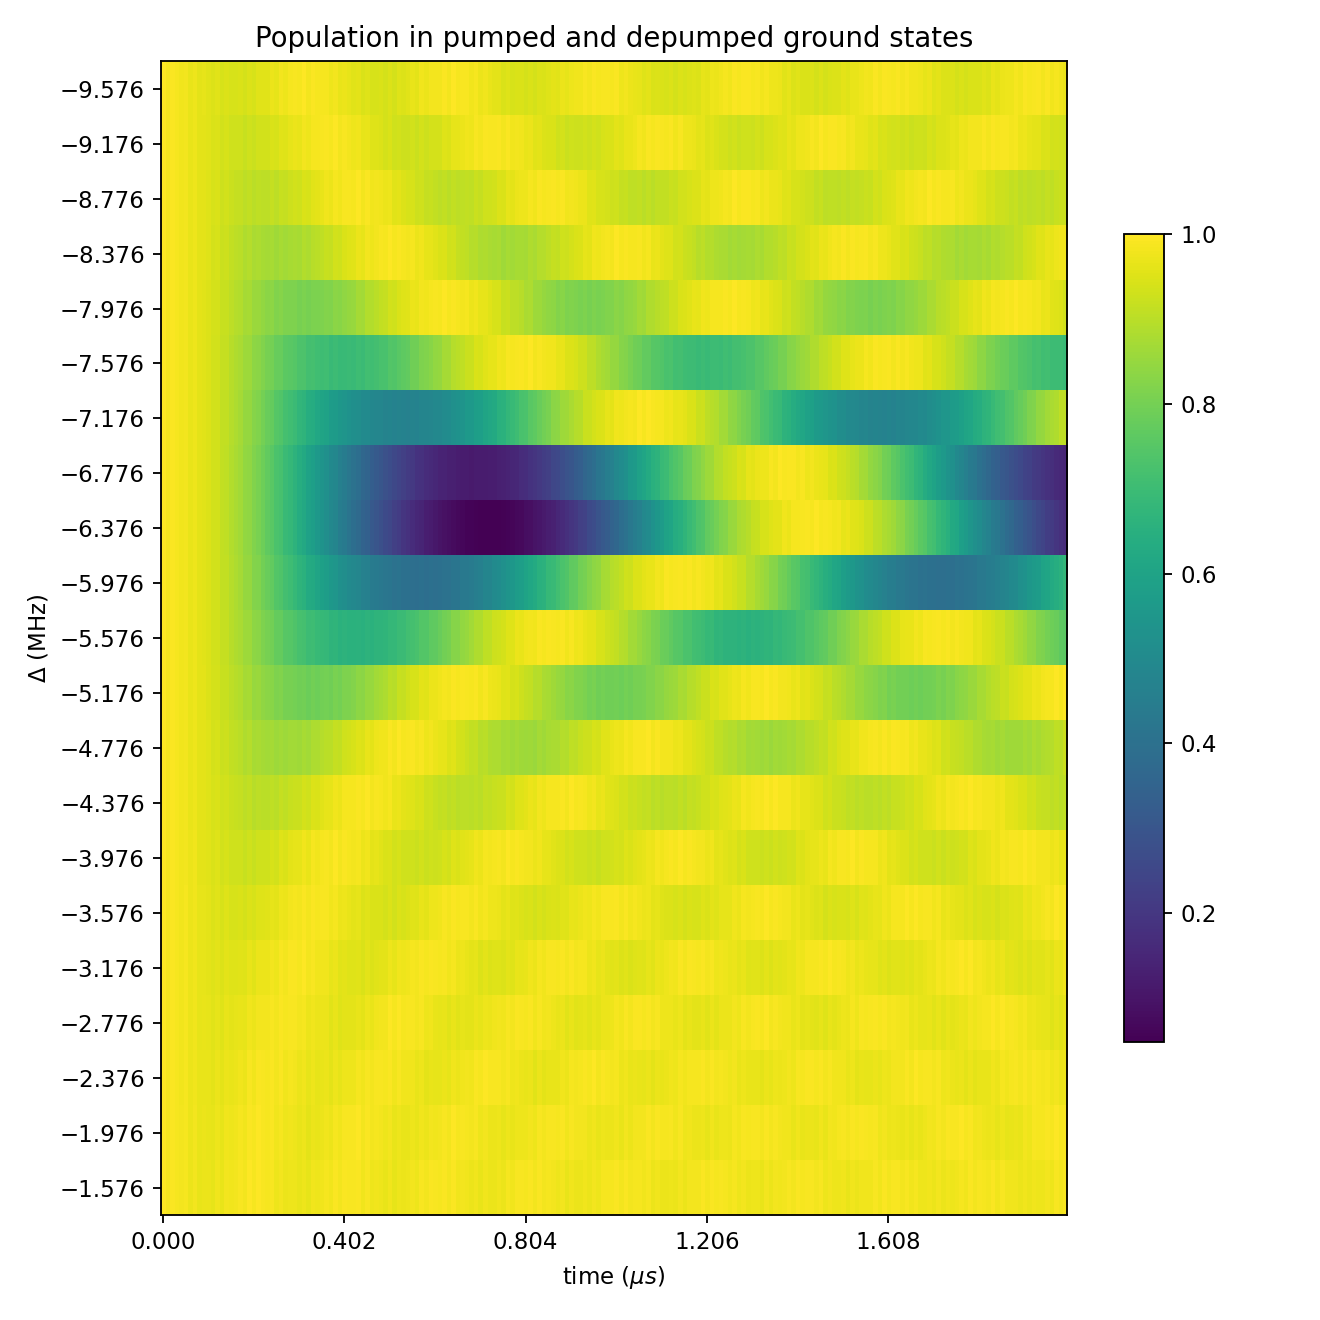

In [488]:
PT = Ps[0] + Ps[aux_ind]
fig,ax = plt.subplots(1,1,figsize=(8,8))
dets = detunings*1e-6/2/pi
detuning_steps = dets[1] - dets[0]
ts = t_list*1e6  # to us
ts_steps = ts[1] - ts[0]
extent = [
    min(ts - ts_steps / 2),  # left
    max(ts + ts_steps / 2),  # right
    max(dets + detuning_steps / 2),  # bottom
    min(dets - detuning_steps / 2)   # top
]
im = ax.imshow(PT, interpolation='none', aspect='auto', extent=extent)
ax.set_xlabel("time ($\mu s$)")
ax.set_ylabel("$\Delta$ (MHz)")
ax.set_xticks(ts[::40])
ax.set_yticks(dets)
ax.set_title(f"Population in pumped and depumped ground states")
fig.tight_layout()
fig.colorbar(im, ax=ax, use_gridspec=True, shrink=.7)
fig.show()
#fig.savefig("PiPulsetom1.png")

# Simulate Rydberg Rabi Oscillations with detuning of choice

In [514]:
det_choice = 2*pi*(-6.50e6) # MHz
m_r = -1/2
t_list = np.linspace(0, 2e-6, 200)

for mr in mrs:
    H_cp[ryd_ind(mr), ryd_ind(mr)] = H[ryd_ind(mr), ryd_ind(mr)] + det_choice

H_qtip = Qobj(H_cp)
result = mesolve(H_qtip, psi_0, t_list, collapse, [], options = Options(nsteps=50000),progress_bar=True)
Ps_dc = np.array(expect([projector(dim,d) for d in range(dim)],result.states))

10.0%. Run time:   0.94s. Est. time left: 00:00:00:08
20.0%. Run time:   1.86s. Est. time left: 00:00:00:07
30.0%. Run time:   2.76s. Est. time left: 00:00:00:06
40.0%. Run time:   3.67s. Est. time left: 00:00:00:05
50.0%. Run time:   4.56s. Est. time left: 00:00:00:04
60.0%. Run time:   5.48s. Est. time left: 00:00:00:03
70.0%. Run time:   6.39s. Est. time left: 00:00:00:02
80.0%. Run time:   7.28s. Est. time left: 00:00:00:01
90.0%. Run time:   8.19s. Est. time left: 00:00:00:00
Total run time:   9.06s


In [515]:
(det_choice-zeeman_R(bias_B,nr,m_r))*1e-6/2/pi

-0.924380102984851

<IPython.core.display.Javascript object>


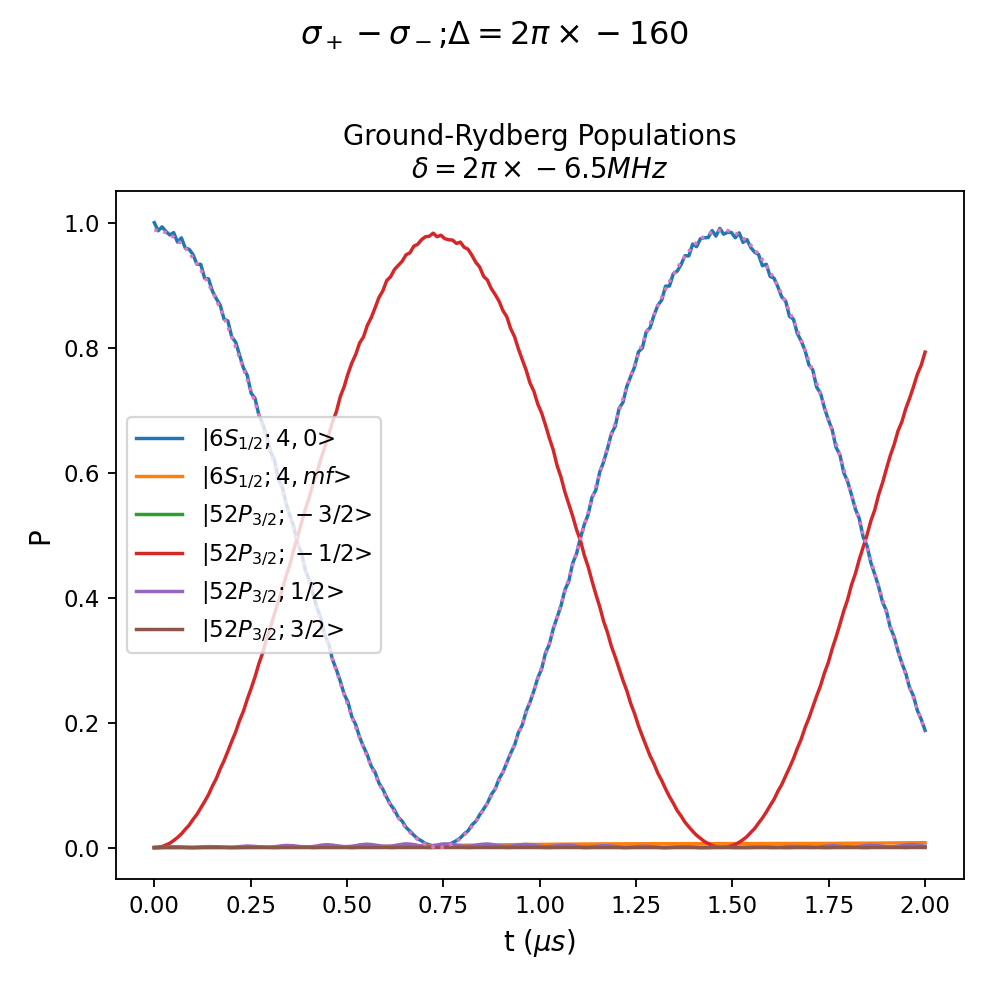

In [516]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

# Plot Rabi Oscillations with Rydberg and Ground states
ax.plot(t_list*1e6, Ps_dc[0, :], label=f"|$6S_{{1/2}};4,0$>")
ax.plot(t_list*1e6, Ps_dc[aux_ind, :], label=f"|$6S_{{1/2}};4,mf$>")
for mr in mrs:
    ax.plot(t_list*1e6, Ps_dc[ryd_ind(mr), :], label=f"|${nr}P_{{3/2}};{int(2*mr)}/2$>")
ax.set_ylabel("P")
ax.set_xlabel("t ($\mu s$)")
ax.set_title(f"Ground-Rydberg Populations\n$\delta = 2\pi\\times {det_choice*1e-6/2/pi:.1f}MHz$")
ax.legend()
#ax.set_xlim(0,2)

func = lambda t, Or, a: a*np.cos(2*pi*1e6*Or*t/2)**2
guess = [
    1.0,
    0.95
]

popt,pcov = curve_fit(func,t_list,Ps_dc[0,:],p0=guess)
perr = np.sqrt(np.diag(pcov))

ax.plot(t_list*1e6,func(t_list,*popt),ls=":",label="fit")

for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    txt.set_fontsize("12")

fig.suptitle(f"{scheme_lab[pol_scheme]};$\Delta=2\pi\\times {intermediate_detuning}$\n",fontsize=14)
fig.tight_layout()
fig.show()

In [517]:
m_r = -1/2
rabi_r = popt[0]  # MHz
dac = -(det_choice-zeeman_R(bias_B,nr,m_r))*1e-6/2/pi
print(f"$\Omega_r^{{({int(2*m_r)}/2)}} = 2\pi \\times {rabi_r:.2f} MHz$")
print(f"$\Delta_{{AC}}^{{({int(2*m_r)}/2)}} = 2\pi \\times {dac:.2f} MHz$")

$\Omega_r^{(-1/2)} = 2\pi \times 0.68 MHz$
$\Delta_{AC}^{(-1/2)} = 2\pi \times 0.92 MHz$


In [518]:
Pryd_else = np.array([Ps_dc[rnd,:] for rnd in np.arange(ryd_ind(-3/2),ryd_ind(3/2)+1) if rnd != ryd_ind(m_r)])
print(f"$\\bar{{P}}_{{re}} = {Pryd_else.mean(1).sum()}$")
print(f"$MAX(P_{{re}}) = {Pryd_else.max(1).sum()}$")

$\bar{P}_{re} = 0.002896576374792196$
$MAX(P_{re}) = 0.008095420741139336$


<IPython.core.display.Javascript object>


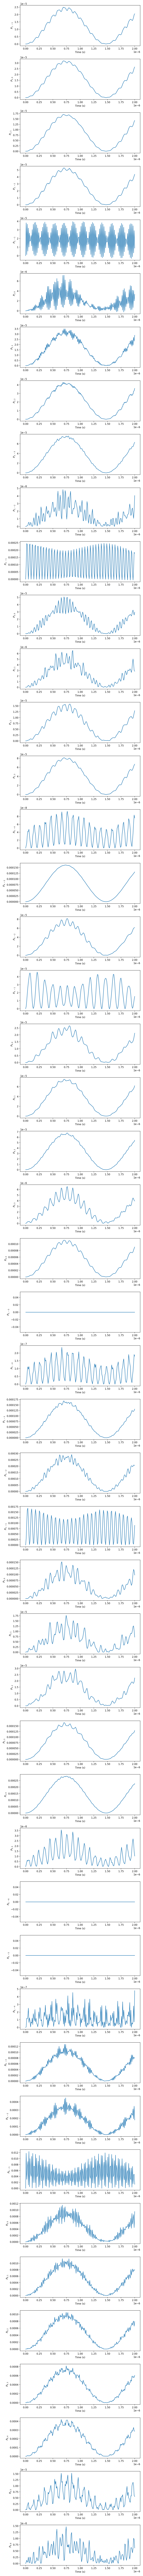

In [519]:
# Plot populations in intermediate states

if fullH:
    finds = range(find(1,-1),find(6,6)+1)
else:
    finds = range(find(1,-1),find(6,2)+1)

fig, axar = plt.subplots(len(finds),1, figsize=(8,3*len(finds)))

c=0
for f in fs:
    for mf in range(-f,f+1):
        if find(f,mf) == -1:
            continue
        ax = axar[c]
        ax.plot(t_list, Ps_dc[find(f,mf), :])
        c += 1
        ax.set_ylabel(f"$P_{{{f},{mf}}}$")
        ax.set_xlabel("Time (s)")
        #ax.set_yscale("log")
#ax.set_title("Total Population in all intermediate states")
#ax.set_yscale("log")

fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


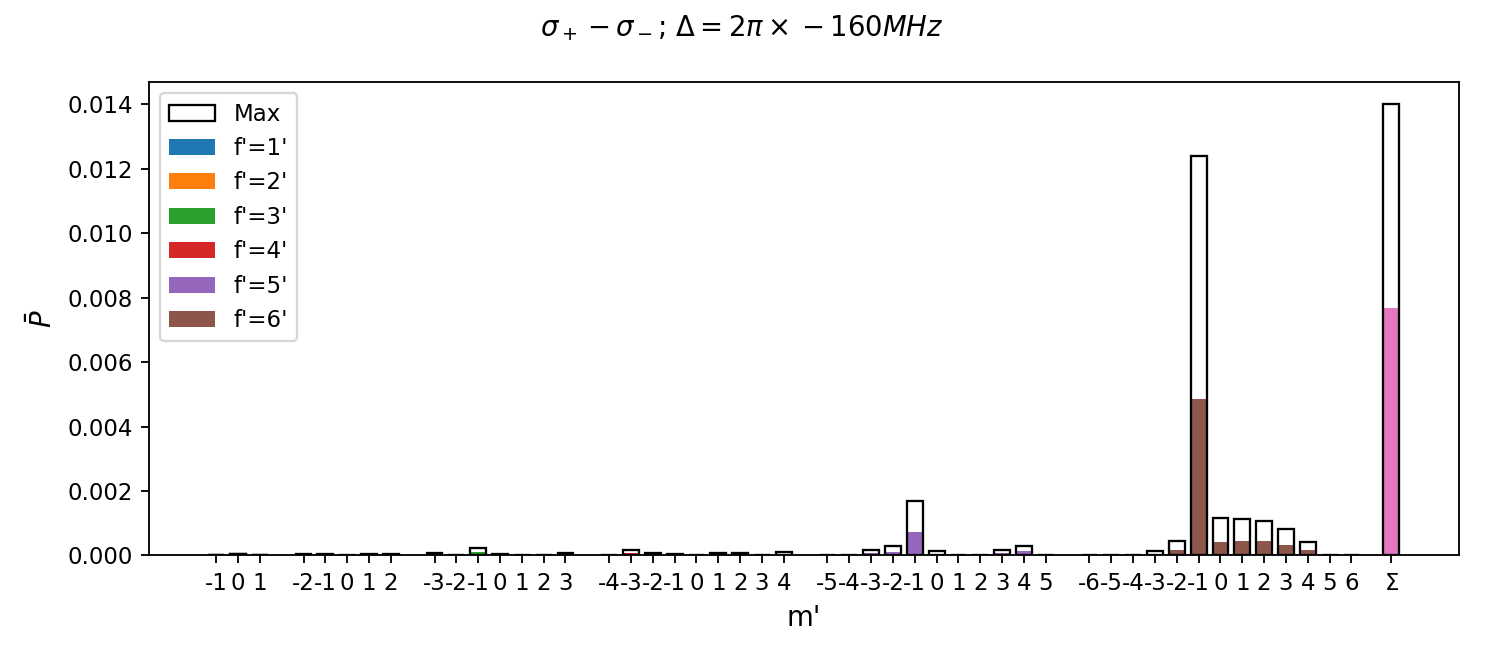

1 [2.2 3.3 4.4]
2 [ 6.6  7.7  8.8  9.9 11. ]
3 [13.2 14.3 15.4 16.5 17.6 18.7 19.8]
4 [22.  23.1 24.2 25.3 26.4 27.5 28.6 29.7 30.8]
5 [33.  34.1 35.2 36.3 37.4 38.5 39.6 40.7 41.8 42.9 44. ]
6 [46.2 47.3 48.4 49.5 50.6 51.7 52.8 53.9 55.  56.1 57.2 58.3 59.4]


In [520]:
fig, ax = plt.subplots(1,1,figsize=(9,4))
w = 1.1
ax.set_xticks([])
i = 0
for f in fs:
    locs = (np.arange(find(f,-f),find(f,f)+1)+f)*w
    print(f,locs)
    mfs = range(-f,f+1)
    Pavs = [Ps_dc[find(f,mf),:].mean() for mf in mfs]
    Pmax = [Ps_dc[find(f,mf),:].max() for mf in mfs]
    
    ax.set_title("")
    if i == 0:
        ax.bar(locs,Pmax,fill=False,color=f"C{i}",label="Max")
        ax.bar(locs,Pavs,label=f"f'={f}'",color=f"C{i}")
        ax.bar(locs,Pmax,fill=False,color=f"C{i}")
    else:
        ax.bar(locs,Pavs,label=f"f'={f}'",color=f"C{i}")
        ax.bar(locs,Pmax,fill=False,color=f"C{i}")
    i+=1
    
ax.bar([max(locs)+2],Ps_dc[find(1,-1):find(6,2),:].sum(0).mean(),color = f"C{i}")
ax.bar([max(locs)+2],Ps_dc[find(1,-1):find(6,2),:].sum(0).max(),fill=False)


#ax.set_yscale("log")
ax.set_ylabel("$\\bar{P}$")

#locs = np.array([(6*(f-1)+2)*w for f in fs]).flatten()
locs_min = []
tick_labs = []
for f in fs:
    locs_min += list(np.arange(find(f,-f),find(f,f)+1)+f)
    tick_labs += range(-f,f+1)
locs_min = np.array(locs_min,dtype=int)*w
locs_min = np.append(locs_min,max(locs_min)+2)
tick_labs += ["$\Sigma$"]

ax.set_xticks(locs_min,minor = False)
ax.set_xticklabels(tick_labs)

ax.set_xlabel("m'")
ax.legend(fontsize=10)

for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    txt.set_fontsize("12")
    
fig.suptitle(f"{scheme_lab[pol_scheme]}; $\Delta = 2\pi\\times{intermediate_detuning}MHz$")#"\nPopulations in $5D_{{5/2}}$",fontsize=12)
fig.tight_layout()
fig.show()
fig.savefig(f"Polarization_analysis\\{pol_scheme}_{intermediate_detuning}_intermediate occupations.png")

# Estimating Phase Errors

In [521]:
# Establish pulse time
Omega_eff = rabi_r*2*pi*1e6
t_2pi = 2*pi/Omega_eff

# Form initial state in super-position of HF ground states (computational states)
psi_ramsey = np.zeros(dim,dtype=complex)
# initialize in super-position of two hyperfine ground states (sorta)
psi_ramsey[0] = 1/np.sqrt(2)
psi_ramsey[-1] = 1/np.sqrt(2)
psi_rq = Qobj(psi_ramsey)

In [522]:
rabi_r, t_2pi

(0.6783462638990957, 1.4741733731266637e-06)

In [523]:
# Define x-operator in Computational basis
X = np.zeros((dim,dim),dtype=complex)
X[0,-1] = 1
X[-1,0] = 1
Xq = Qobj(X)

# Define y-operator in Computational basis
Y = np.zeros((dim,dim),dtype=complex)
Y[0,-1] = -1j
Y[-1,0] = 1j
Yq = Qobj(Y)

In [538]:
t_list = np.linspace(0, 2*t_2pi, 1000)

for mr in mrs:
    H_cp[ryd_ind(mr), ryd_ind(mr)] = H[ryd_ind(mr), ryd_ind(mr)] + det_choice

H_qtip = Qobj(H_cp)
result = mesolve(H_qtip, psi_rq, t_list, collapse, [], options = Options(nsteps=50000),progress_bar=True)
Ps_dc = np.array(expect([projector(dim,d) for d in range(dim)],result.states))
X_dc = expect(Xq,result.states)
Y_dc = expect(Yq,result.states)

10.0%. Run time:   1.28s. Est. time left: 00:00:00:11
20.0%. Run time:   2.61s. Est. time left: 00:00:00:10
30.0%. Run time:   3.89s. Est. time left: 00:00:00:09
40.0%. Run time:   5.17s. Est. time left: 00:00:00:07
50.0%. Run time:   6.46s. Est. time left: 00:00:00:06
60.0%. Run time:   7.73s. Est. time left: 00:00:00:05
70.0%. Run time:   9.01s. Est. time left: 00:00:00:03
80.0%. Run time:  10.28s. Est. time left: 00:00:00:02
90.0%. Run time:  11.55s. Est. time left: 00:00:00:01
Total run time:  12.82s


<IPython.core.display.Javascript object>


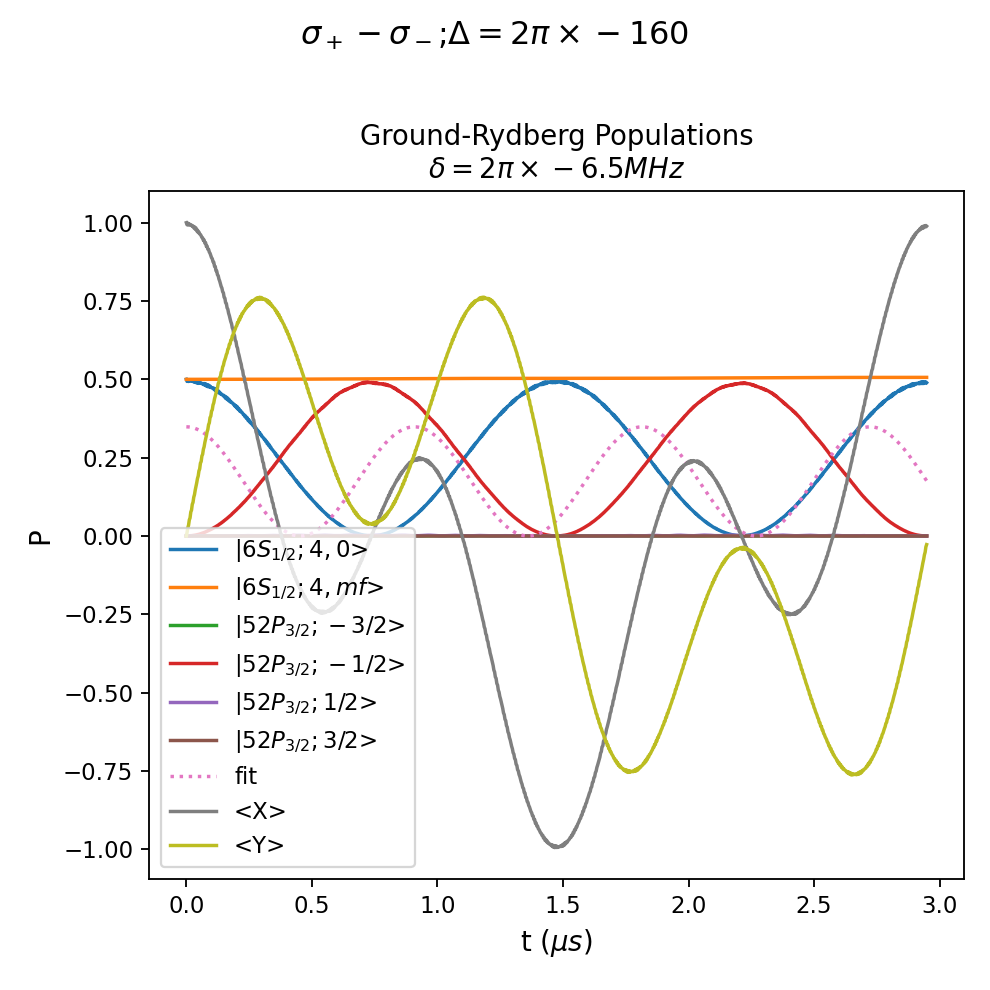

In [539]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

# Plot Rabi Oscillations with Rydberg and Ground states
ax.plot(t_list*1e6, Ps_dc[0, :], label=f"|$6S_{{1/2}};4,0$>")
ax.plot(t_list*1e6, Ps_dc[aux_ind, :], label=f"|$6S_{{1/2}};4,mf$>")
for mr in mrs:
    ax.plot(t_list*1e6, Ps_dc[ryd_ind(mr), :], label=f"|${nr}P_{{3/2}};{int(2*mr)}/2$>")
#ax.set_xlim(0,2)

func = lambda t, Or, a: a*np.cos(2*pi*1e6*Or*t/2)**2
guess = [
    1.0,
    0.95
]

popt,pcov = curve_fit(func,t_list,Ps_dc[0,:],p0=guess)
perr = np.sqrt(np.diag(pcov))

ax.plot(t_list*1e6,func(t_list,*popt),ls=":",label="fit")



ax.set_ylabel("P")
ax.set_xlabel("t ($\mu s$)")
ax.set_title(f"Ground-Rydberg Populations\n$\delta = 2\pi\\times {det_choice*1e-6/2/pi:.1f}MHz$")
ax.legend()

for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    txt.set_fontsize("12")

fig.suptitle(f"{scheme_lab[pol_scheme]};$\Delta=2\pi\\times {intermediate_detuning}$\n",fontsize=14)
fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


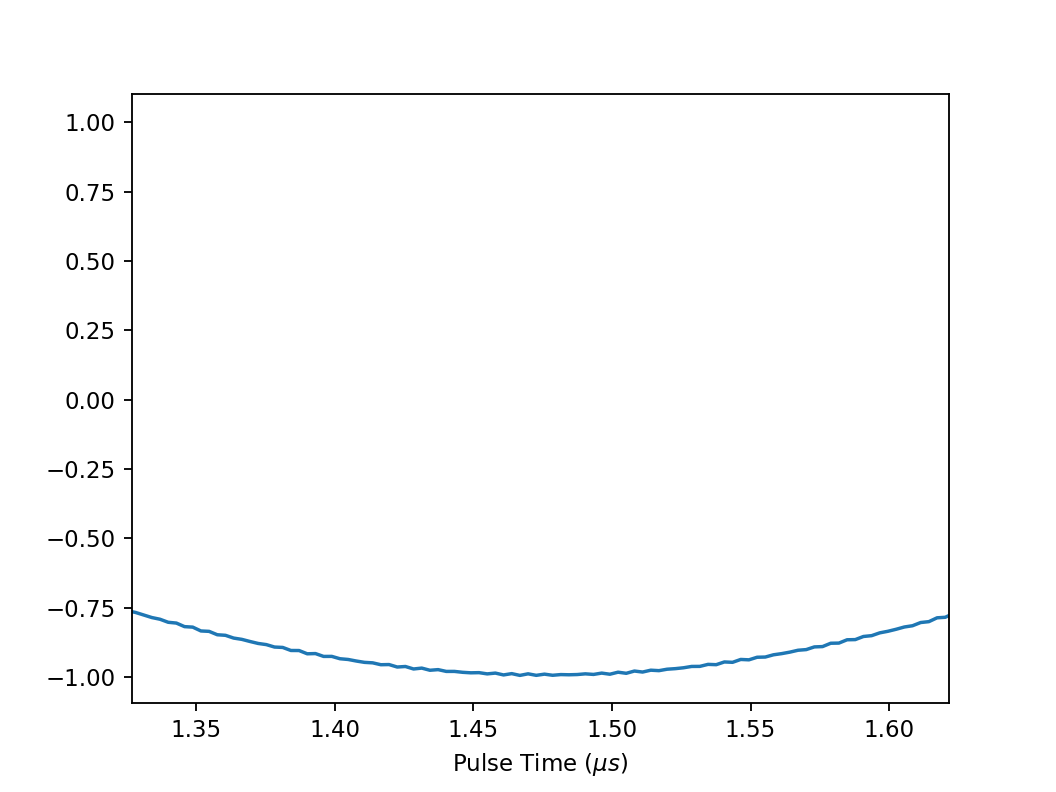

In [547]:
PhiX = np.arccos(X_dc)
PhiY = np.arcsin(Y_dc)
fig,ax = plt.subplots(1,1)
ax.plot(t_list*1e6,X_dc,label="<X>")
#ax.plot(t_list*1e6,Y_dc,label="<Y>")
#ax.set_ylabel("$\\frac{\phi}{2\pi}$")
ax.set_xlabel("Pulse Time ($\mu s$)")
ax.set_xlim(1e6*t_2pi*(1-0.1),1e6*t_2pi*(1+0.1))
fig.show()

In [544]:
t_2pi

1.4741733731266637e-06

In [535]:
st_last = result.states[-1]
rho_last_qb = Qobj([
    [st_last[0,0],st_last[0,-1]],
    [st_last[-1,0],st_last[-1,-1]]
              ])

In [536]:
rho_last_qb

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.48939625+2.46213587e-17j 0.49443425+1.37202948e-02j]
 [0.49443425-1.37202948e-02j 0.506314  -8.13785008e-20j]]

In [537]:
print(np.angle(rho_last_qb[0,1])/pi)
print(X_dc[-1])
print(Y_dc[-1])

0.008830668598399878
0.9888685023505525
-0.027440589681372682


In [305]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

# Plot Rabi Oscillations with Rydberg and Ground states
ax.plot(t_list*1e6, Ps_dc[0, :], label=f"|$6S_{{1/2}};4,0$>")
ax.plot(t_list*1e6, Ps_dc[aux_ind, :], label=f"|$6S_{{1/2}};4,mf$>")
for mr in mrs:
    ax.plot(t_list*1e6, Ps_dc[ryd_ind(mr), :], label=f"|${nr}P_{{3/2}};{int(2*mr)}/2$>")
ax.set_ylabel("P")
ax.set_xlabel("t ($\mu s$)")
ax.set_title(f"Ground-Rydberg Populations\n$\delta = 2\pi\\times {det_choice*1e-6/2/pi:.1f}MHz$")
ax.legend()
#ax.set_xlim(0,2)

func = lambda t, Or, a: a*np.cos(2*pi*1e6*Or*t/2)**2
guess = [
    1.0,
    0.95
]

popt,pcov = curve_fit(func,t_list,Ps_dc[0,:],p0=guess)
perr = np.sqrt(np.diag(pcov))

ax.plot(t_list*1e6,func(t_list,*popt),ls=":",label="fit")

for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    txt.set_fontsize("12")

fig.suptitle(f"{scheme_lab[pol_scheme]};$\Delta=2\pi\\times {intermediate_detuning}$\n",fontsize=14)
fig.tight_layout()
fig.show()

array([ 2.2,  3.3,  4.4,  6.6,  7.7,  8.8,  9.9, 11. , 13.2, 14.3, 15.4,
       16.5, 17.6, 18.7, 19.8, 22. , 23.1, 24.2, 25.3, 26.4, 27.5, 28.6,
       29.7, 30.8, 33. , 34.1, 35.2, 36.3, 37.4, 38.5, 39.6, 40.7, 41.8,
       42.9, 44. , 46.2, 47.3, 48.4, 49.5, 50.6, 51.7, 52.8, 53.9, 55. ,
       56.1, 57.2, 58.3, 59.4])

In [299]:
[1,2]+[3,4,5]

[1, 2, 3, 4, 5]

In [67]:
help(ax.set_xticks)

Help on method set_xticks in module matplotlib.axes._base:

set_xticks(ticks, *, minor=False) method of matplotlib.axes._subplots.AxesSubplot instance
    Set the xaxis' tick locations.
    
    Parameters
    ----------
    ticks : list of floats
        List of tick locations.
    minor : bool, default: False
        If ``False``, set the major ticks; if ``True``, the minor ticks.



In [37]:
gj = 2.002
gi = 0

dB = 1e-3*gauss

dClock = (gj-gi)**2*mub**2/(2*hb**2*(2*pi*9.19263e9))*bias_B*dB


In [38]:
dClock/2/pi

2.135263368051464

In [34]:
mub

9.274009994e-24

## Debug ME solver

Use simplified Hilbert Space consisting of three states (g,e,r)

Use: 
$$\Omega_{g;6,-1} = \Omega_1$$
$$\Omega_{6,-1;-1/2} = \Omega_2$$

and detuning
$$ \Delta = 2\pi \times 80 MHz$$

Estimated FoM:

$$\Omega_r = -\frac{\Omega_1 \Omega_2}{2\Delta} $$
$$\Delta_{AC} = \frac{\Omega_1^2-\Omega_2^2}{4\Delta} $$
$$\bar{P}_{e} = \frac{\Omega_1^2+\Omega_2^2}{4\Delta^2} $$

FoM will be evaluated for the simulation and compared to the estimated FoM

In [140]:
ft = 6
mft = -1
mrt = -1/2

O1 = 2*H[0,find(ft,mft)]
O2 = 2*H[find(ft,mft),ryd_ind(mrt)]

Delta = 4*pi*80e6

# FoM Estimates
OrE = O1*O2/2/Delta  # radians/s
DacE = (abs(O1)**2-abs(O2)**2)/4/Delta  # radians/s
PeE = (abs(O1)**2+abs(O2)**2)/4/Delta**2  # fraction

print(O1/2/pi*1e-6,O2/2/pi*1e-6)

Hdb = np.array([
    [0,O1/2,0],
    [O1.conj()/2,Delta,O2/2],
    [0,O2.conj()/2,0]
],dtype=complex)

12.52592458404585j (14.108067831428079+0j)


In [141]:
tpiE = pi/abs(OrE)
t_list = np.linspace(0,4*tpiE,300)
detunings_db = np.linspace(-2*pi*5,2*pi*5,21)*1e6
Psdb = np.zeros((3,len(detunings_db), len(t_list)), dtype = float)
psi_0db = basis(3,0)

Hcopy = Hdb.copy()
for i,det in enumerate(detunings_db):
    Hcopy[2,2] = Hdb[2,2] + det

    Hqt = Qobj(Hcopy)
    result = mesolve(Hqt, psi_0db, t_list, [], [], options=Options(nsteps=50000))
    Psdb[:,i,:] = expect([projector(3,d) for d in range(3)], result.states)

<IPython.core.display.Javascript object>


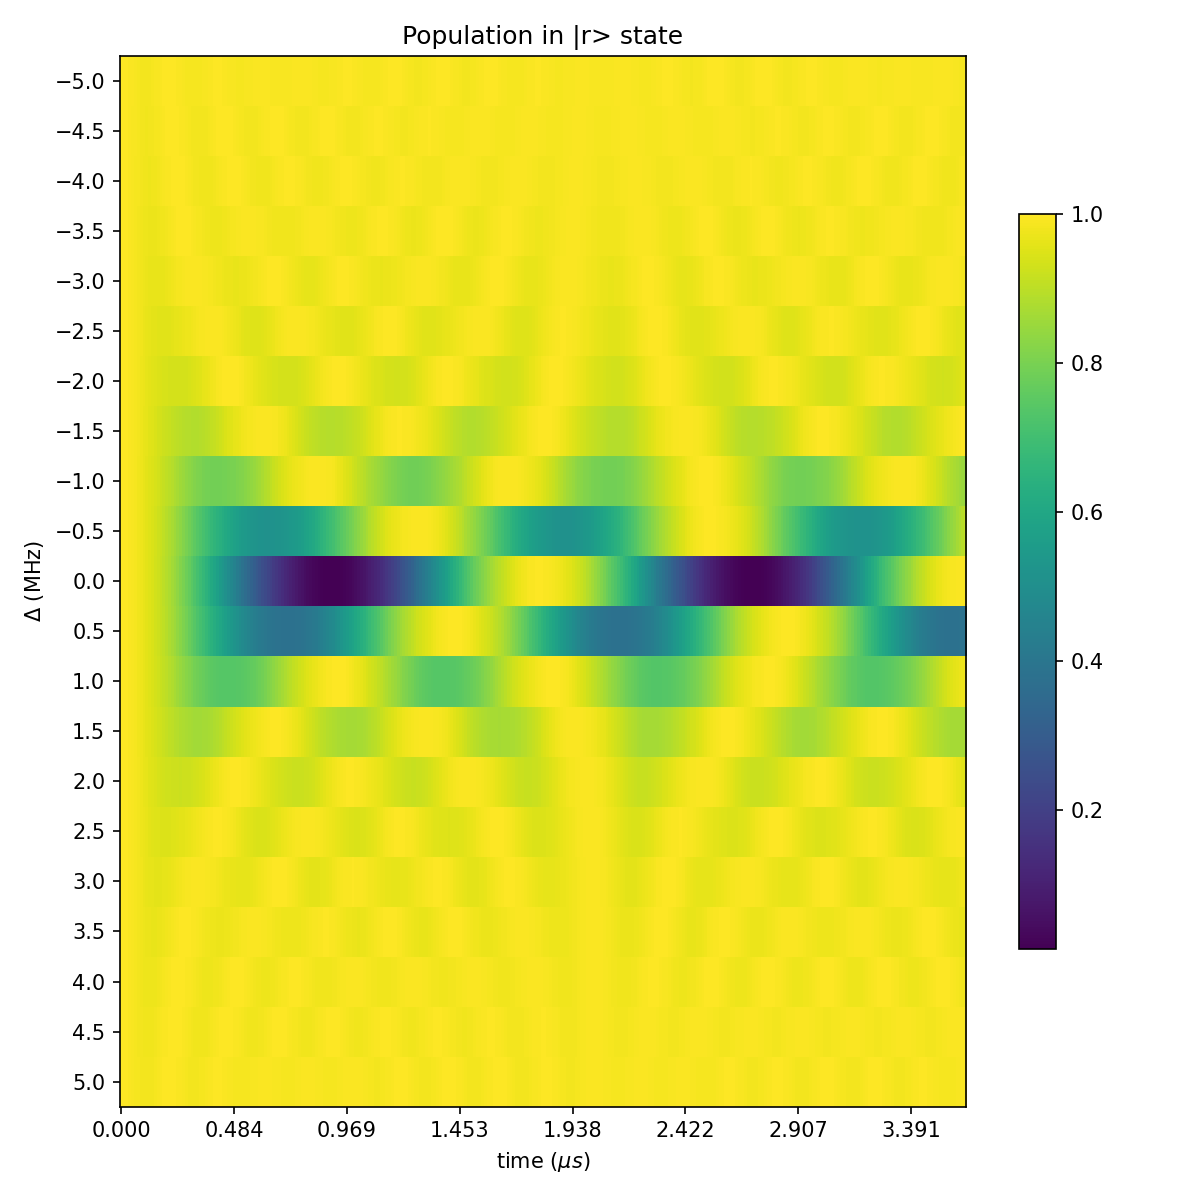

In [142]:
PT = Psdb[0]
fig,ax = plt.subplots(1,1,figsize=(8,8))
dets = detunings_db*1e-6/2/pi
detuning_steps = dets[1] - dets[0]
ts = t_list*1e6  # to us
ts_steps = ts[1] - ts[0]
extent = [
    min(ts - ts_steps / 2),  # left
    max(ts + ts_steps / 2),  # right
    max(dets + detuning_steps / 2),  # bottom
    min(dets - detuning_steps / 2)   # top
]
im = ax.imshow(PT, interpolation='none', aspect='auto', extent=extent)
ax.set_xlabel("time ($\mu s$)")
ax.set_ylabel("$\Delta$ (MHz)")
ax.set_xticks(ts[::40])
ax.set_yticks(dets)
ax.set_title(f"Population in |r> state")
fig.tight_layout()
fig.colorbar(im, ax=ax, use_gridspec=True, shrink=.7)
fig.show()

In [143]:
det_choice = 2*pi*(0.1e6) # MHz
#t_list = np.linspace(0, 1e-6, 200)

Hcopy[2,2] = Hdb[2,2] + det_choice

H_qtip = Qobj(Hcopy)
result = mesolve(H_qtip, psi_0db, t_list, [], [], options = Options(nsteps=50000))
Ps_dcdb = np.array(expect([projector(3,d) for d in range(3)],result.states))

<IPython.core.display.Javascript object>


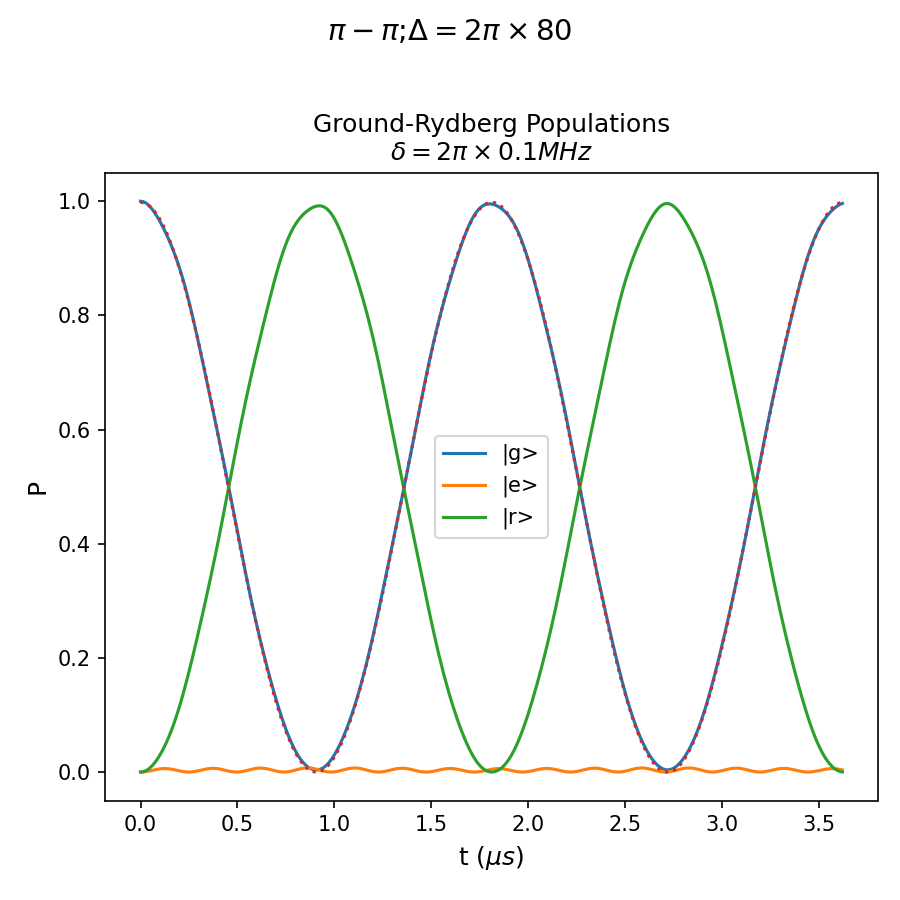

In [144]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

# Plot Rabi Oscillations with Rydberg and Ground states
ax.plot(t_list*1e6, Ps_dcdb[0, :], label=f"|g>")
ax.plot(t_list*1e6, Ps_dcdb[1, :], label=f"|e>")
ax.plot(t_list*1e6, Ps_dcdb[2, :], label=f"|r>")

ax.set_ylabel("P")
ax.set_xlabel("t ($\mu s$)")
ax.set_title(f"Ground-Rydberg Populations\n$\delta = 2\pi\\times {det_choice*1e-6/2/pi:.1f}MHz$")
ax.legend()
#ax.set_xlim(0,2)

func = lambda t, Or, a: a*np.cos(2*pi*1e6*Or*t/2)**2
guess = [
    abs(OrE*1e-6/2/pi),
    0.95
]

popt,pcov = curve_fit(func,t_list,Ps_dcdb[0,:],p0=guess)
perr = np.sqrt(np.diag(pcov))

ax.plot(t_list*1e6,func(t_list,*popt),ls=":",label="fit")
#ax.plot(t_list*1e6,func(t_list,*guess),ls=":",label="fit")


for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    txt.set_fontsize("12")

fig.suptitle(f"{scheme_lab[pol_scheme]};$\Delta=2\pi\\times {intermediate_detuning}$\n",fontsize=14)
fig.tight_layout()
fig.show()

In [145]:
# Comparing FoM
OrS = popt[0]
OrEH = abs(OrE)/2/pi*1e-6
erO  = 1 - abs(OrEH)/abs(OrS)

DacS = -det_choice/2/pi*1e-6
DacEH = DacE/2/pi*1e-6
erD = 1 - DacEH/DacS

PeS = Ps_dcdb[1,:].mean()
erP = 1 - PeE/PeS

print(f"Omega Analytical = 2\pi \\times {OrEH:.2f} MHz\nOmega Simulated = 2\pi \\times {OrS:.2f} MHz\n Error = {100*erO:.1f}%")
print(f"D_AC Analytical = 2\pi \\times {DacEH:.2f} MHz\nOmega Simulated = 2\pi \\times {DacS:.2f} MHz\n Error = {100*erD:.1f}%")
print(f"Omega Analytical = 2\pi \\times {PeE:.2e} MHz\nOmega Simulated = 2\pi \\times {PeS:.2e} MHz\n Error = {100*erP:.1f}%")

Omega Analytical = 2\pi \times 0.55 MHz
Omega Simulated = 2\pi \times 0.55 MHz
 Error = -0.1%
D_AC Analytical = 2\pi \times -0.07 MHz
Omega Simulated = 2\pi \times -0.10 MHz
 Error = 34.2%
Omega Analytical = 2\pi \times 3.48e-03 MHz
Omega Simulated = 2\pi \times 3.35e-03 MHz
 Error = -3.8%


### Multiple Excitation Paths

Modify Above Hilbert Space to add two excitation paths (g,em,ep,r)

Use: 
$$\Omega_{g;6,-1} = \Omega_1m$$
$$\Omega_{g;6,1} = \Omega_1p$$

$$\Omega_{6,-1;-1/2} = \Omega_2m$$
$$\Omega_{6,1;-1/2} = \Omega_2p$$

and detuning
$$ \Delta = 2\pi \times 80 MHz$$

Estimated FoM:

$$\Omega_r = -\sum_{i}\frac{\Omega_{1i} \Omega_{2i}}{2\Delta} $$
$$\Delta_{AC} = \sum_{i}\frac{\Omega_{1i}^2-\Omega_{2i}^2}{4\Delta} $$
$$\bar{P}_{e} = \sum_{i}\frac{\Omega_{1i}^2+\Omega_{2i}^2}{4\Delta^2} $$

FoM will be evaluated for the simulation and compared to the estimated FoM

In [196]:
ft = 6
mfp = 1
mfm = -1
mrt = -1/2
ddim = 4

O1m = 2*H[0,find(ft,mfm)]
O1p = 2*H[0,find(ft,mfp)]

O2m = 2*H[find(ft,mfm),ryd_ind(mrt)]
O2p = 2*H[find(ft,mfp),ryd_ind(mrt)]

Delta = -2*pi*80e6

# FoM Estimates
OrE = (O1m*O2m+O1p*O2p)/2/Delta  # radians/s
DacE = (abs(O1m)**2+abs(O1p)**2-abs(O2m)**2-abs(O2p)**2)/4/Delta  # radians/s
PeE = (abs(O1m)**2+abs(O1p)**2+abs(O2m)**2+abs(O2p)**2)/4/Delta**2  # fraction

print(O1/2/pi*1e-6,O2/2/pi*1e-6)

Hdb = np.array([
    [0,O1m/2,O1p/2,0],
    [O1m.conj()/2,Delta,0,O2m/2],
    [O1p.conj()/2,0,Delta,O2p/2],
    [0,O2m.conj()/2,O2p.conj()/2,0]
],dtype=complex)

12.52592458404585j (14.108067831428079+0j)


In [197]:
tpiE = pi/abs(OrE)
t_list = np.linspace(0,4*tpiE,300)
detunings_db = np.linspace(-2*pi*1,2*pi*1,21)*1e6
Psdb = np.zeros((ddim,len(detunings_db), len(t_list)), dtype = float)
psi_0db = basis(ddim,0)

Hcopy = Hdb.copy()
for i,det in enumerate(detunings_db):
    Hcopy[ddim-1,ddim-1] = Hdb[ddim-1,ddim-1] + det

    Hqt = Qobj(Hcopy)
    result = mesolve(Hqt, psi_0db, t_list, [], [], options=Options(nsteps=50000))
    Psdb[:,i,:] = expect([projector(ddim,d) for d in range(ddim)], result.states)

In [198]:
Hqt/2/pi*1e-6

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[  0.        +0.j           0.        +6.26296229j
    0.        -6.26296229j   0.        +0.j        ]
 [  0.        -6.26296229j -80.        +0.j
    0.        +0.j           7.05403392+0.j        ]
 [  0.        +6.26296229j   0.        +0.j
  -80.        +0.j           5.46403118+0.j        ]
 [  0.        +0.j           7.05403392+0.j
    5.46403118+0.j           1.        +0.j        ]]

<IPython.core.display.Javascript object>


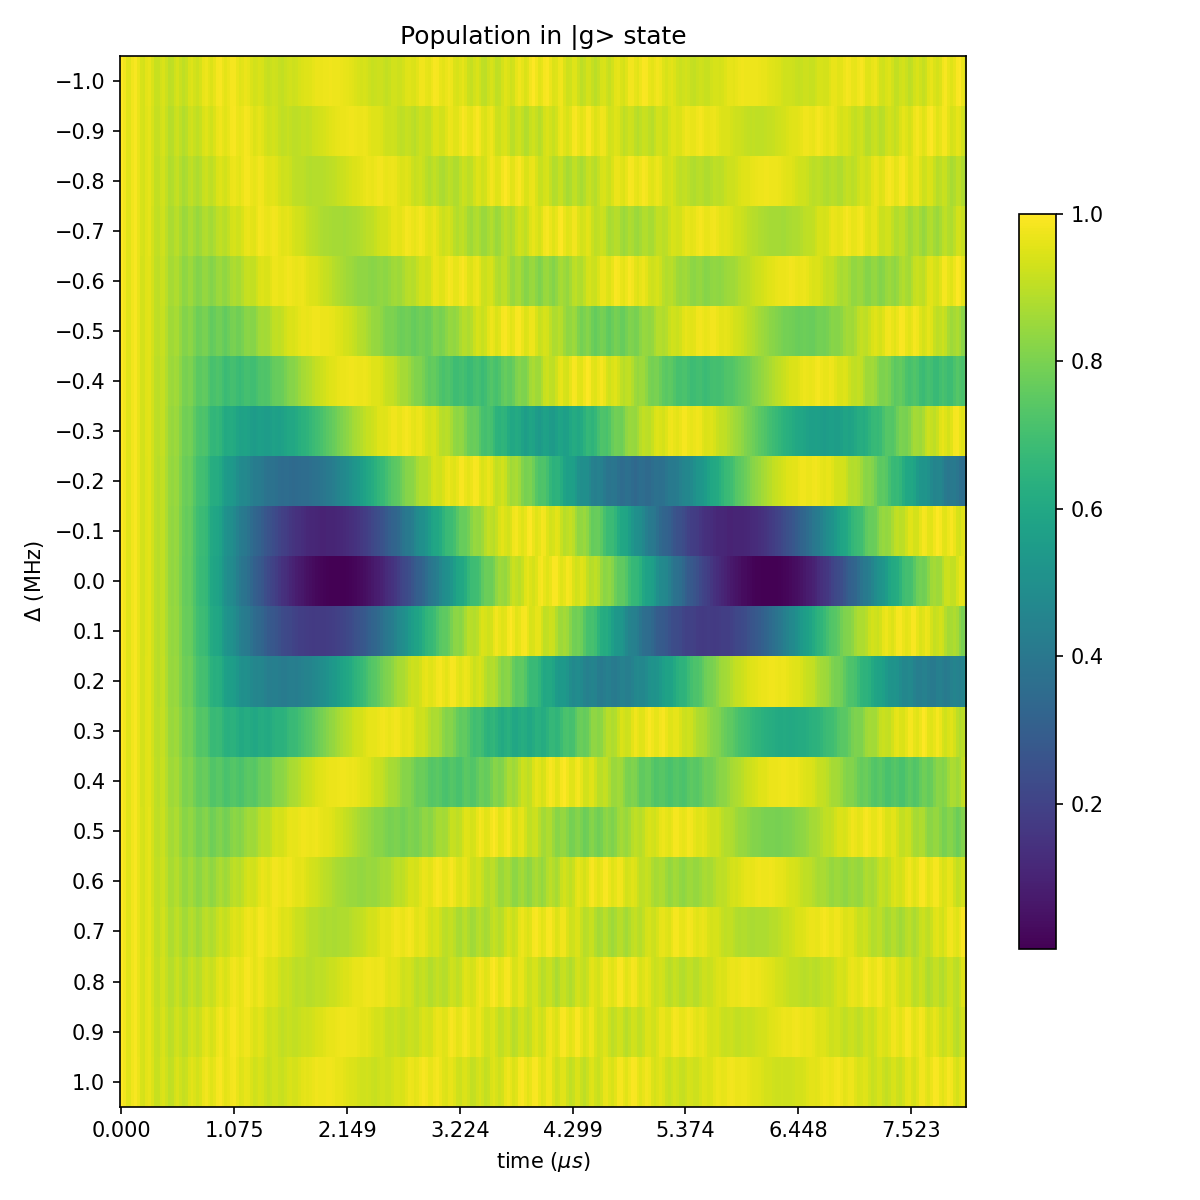

In [199]:
PT = Psdb[0]
fig,ax = plt.subplots(1,1,figsize=(8,8))
dets = detunings_db*1e-6/2/pi
detuning_steps = dets[1] - dets[0]
ts = t_list*1e6  # to us
ts_steps = ts[1] - ts[0]
extent = [
    min(ts - ts_steps / 2),  # left
    max(ts + ts_steps / 2),  # right
    max(dets + detuning_steps / 2),  # bottom
    min(dets - detuning_steps / 2)   # top
]
im = ax.imshow(PT, interpolation='none', aspect='auto', extent=extent)
ax.set_xlabel("time ($\mu s$)")
ax.set_ylabel("$\Delta$ (MHz)")
ax.set_xticks(ts[::40])
ax.set_yticks(dets)
ax.set_title(f"Population in |g> state")
fig.tight_layout()
fig.colorbar(im, ax=ax, use_gridspec=True, shrink=.7)
fig.show()

In [200]:
det_choice = 2*pi*(0.01e6) # MHz
#t_list = np.linspace(0, 1e-6, 200)

Hcopy[-1,-1] = Hdb[-1,-1] + det_choice

H_qtip = Qobj(Hcopy)
result = mesolve(H_qtip, psi_0db, t_list, [], [], options = Options(nsteps=50000))
Ps_dcdb = np.array(expect([projector(ddim,d) for d in range(ddim)],result.states))

<IPython.core.display.Javascript object>


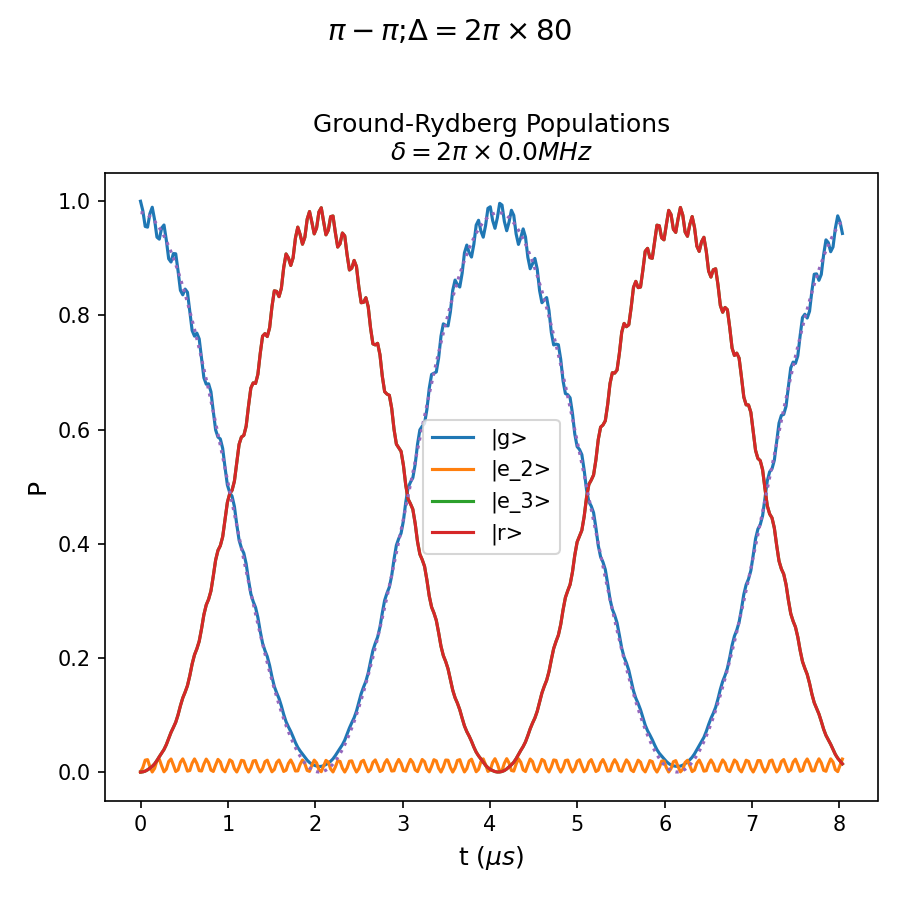

In [201]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

# Plot Rabi Oscillations with Rydberg and Ground states
ax.plot(t_list*1e6, Ps_dcdb[0, :], label=f"|g>")
for i in range(2,ddim):
    ax.plot(t_list*1e6, Ps_dcdb[i, :], label=f"|e_{i}>")
ax.plot(t_list*1e6, Ps_dcdb[-1, :], label=f"|r>")

ax.set_ylabel("P")
ax.set_xlabel("t ($\mu s$)")
ax.set_title(f"Ground-Rydberg Populations\n$\delta = 2\pi\\times {det_choice*1e-6/2/pi:.1f}MHz$")
ax.legend()
#ax.set_xlim(0,2)

func = lambda t, Or, a: a*np.cos(2*pi*1e6*Or*t/2)**2
guess = [
    abs(OrE*1e-6/2/pi),
    0.95
]

popt,pcov = curve_fit(func,t_list,Ps_dcdb[0,:],p0=guess)
perr = np.sqrt(np.diag(pcov))

ax.plot(t_list*1e6,func(t_list,*popt),ls=":",label="fit")
#ax.plot(t_list*1e6,func(t_list,*guess),ls=":",label="fit")


for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    txt.set_fontsize("12")

fig.suptitle(f"{scheme_lab[pol_scheme]};$\Delta=2\pi\\times {intermediate_detuning}$\n",fontsize=14)
fig.tight_layout()
fig.show()

In [202]:
# Comparing FoM
OrS = popt[0]
OrEH = abs(OrE)/2/pi*1e-6
erO  = 1 - abs(OrEH)/abs(OrS)

DacS = -det_choice/2/pi*1e-6
DacEH = DacE/2/pi*1e-6
erD = 1 - DacEH/DacS

PeS = Ps_dcdb[1,:].mean()
erP = 1 - PeE/PeS

print(f"Omega Analytical = 2\pi \\times {OrEH:.2f} MHz\nOmega Simulated = 2\pi \\times {OrS:.2f} MHz\n Error = {100*erO:.1f}%")
print(f"D_AC Analytical = 2\pi \\times {DacEH:.2f} MHz\nOmega Simulated = 2\pi \\times {DacS:.2f} MHz\n Error = {100*erD:.1f}%")
print(f"Omega Analytical = 2\pi \\times {PeE:.2e} MHz\nOmega Simulated = 2\pi \\times {PeS:.2e} MHz\n Error = {100*erP:.1f}%")

Omega Analytical = 2\pi \times 0.25 MHz
Omega Simulated = 2\pi \times 0.24 MHz
 Error = -1.9%
D_AC Analytical = 2\pi \times 0.01 MHz
Omega Simulated = 2\pi \times -0.01 MHz
 Error = 245.7%
Omega Analytical = 2\pi \times 2.47e-02 MHz
Omega Simulated = 2\pi \times 1.21e-02 MHz
 Error = -104.1%


In [50]:
R = 1.8e6# Ohm
np.sqrt(R)

1341.640786499874

In [217]:
def find2(f,mf):
    if abs(mf) > f:
        return -1
    if f not in fs:
        return -1
    return 2+f**2+f-1+mf

In [218]:
for f in fs:
    for mf in range(-f,f+1,1):
        print(f"f,mf={f},{mf}:\n\tfind={find2(f,mf)}")

f,mf=1,-1:
	find=2
f,mf=1,0:
	find=3
f,mf=1,1:
	find=4
f,mf=2,-2:
	find=5
f,mf=2,-1:
	find=6
f,mf=2,0:
	find=7
f,mf=2,1:
	find=8
f,mf=2,2:
	find=9
f,mf=3,-3:
	find=10
f,mf=3,-2:
	find=11
f,mf=3,-1:
	find=12
f,mf=3,0:
	find=13
f,mf=3,1:
	find=14
f,mf=3,2:
	find=15
f,mf=3,3:
	find=16
f,mf=4,-4:
	find=17
f,mf=4,-3:
	find=18
f,mf=4,-2:
	find=19
f,mf=4,-1:
	find=20
f,mf=4,0:
	find=21
f,mf=4,1:
	find=22
f,mf=4,2:
	find=23
f,mf=4,3:
	find=24
f,mf=4,4:
	find=25
f,mf=5,-5:
	find=26
f,mf=5,-4:
	find=27
f,mf=5,-3:
	find=28
f,mf=5,-2:
	find=29
f,mf=5,-1:
	find=30
f,mf=5,0:
	find=31
f,mf=5,1:
	find=32
f,mf=5,2:
	find=33
f,mf=5,3:
	find=34
f,mf=5,4:
	find=35
f,mf=5,5:
	find=36
f,mf=6,-6:
	find=37
f,mf=6,-5:
	find=38
f,mf=6,-4:
	find=39
f,mf=6,-3:
	find=40
f,mf=6,-2:
	find=41
f,mf=6,-1:
	find=42
f,mf=6,0:
	find=43
f,mf=6,1:
	find=44
f,mf=6,2:
	find=45
f,mf=6,3:
	find=46
f,mf=6,4:
	find=47
f,mf=6,5:
	find=48
f,mf=6,6:
	find=49


In [220]:
dim2 = 48+2+4
dim2

54

In [221]:
dim

34